# Wrangling data in Tables

## David Culler

This notebook illustrates several of the datascience tables methods for wrangling typical data.
Here we use some simple census data.  Even that is pretty obscure.  We illustrate the process 
of going from raw data to a distilled form and then answer a simple question: "How does the
relative difference of males and females vary with age?" The answer, there are bit more boys,
but a LOT less old men.

In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

Construct a raw table from a csv on the web

In [2]:
census_url = 'http://www.census.gov/popest/data/national/asrh/2014/files/NC-EST2014-AGESEX-RES.csv'
raw_census = Table.read_table(census_url)
raw_census

SEX,AGE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014
0,0,3944153,3944160,3951330,3963071,3926665,3945610,3948350
0,1,3978070,3978090,3957888,3966510,3978006,3943077,3962123
0,2,4096929,4096939,4090862,3971573,3979952,3992690,3957772
0,3,4119040,4119051,4111920,4102501,3983049,3992425,4005190
0,4,4063170,4063186,4077552,4122303,4112638,3994047,4003448
0,5,4056858,4056872,4064653,4087713,4132210,4123408,4004858
0,6,4066381,4066412,4073013,4074979,4097780,4143094,4134352
0,7,4030579,4030594,4043047,4083240,4084964,4108615,4154000
0,8,4046486,4046497,4025604,4053206,4093213,4095827,4119524
0,9,4148353,4148369,4125415,4035769,4063193,4104133,4106832


## Stage 1: cleaning up columns and encodings

As is often the case, the data you find is pretty ugly.  

In [3]:
# A simple tool to decode an encoding
def categorize_sex(s):
   return ['all','male','female'][s]

In [4]:
# Keep only what we need
pre_census = raw_census.select(['SEX', 'AGE', 'CENSUS2010POP', 'POPESTIMATE2014'])
# Clean up the column names
pre_census.relabel('CENSUS2010POP','2010pop')
pre_census.relabel('POPESTIMATE2014','2014est')
# Decode the categories
pre_census['CAT'] = pre_census.apply(categorize_sex, 'SEX')
# Create a new clean table getting rid of what we can
p2_census = pre_census.drop('SEX')
p2_census.move_to_start('CAT')
p2_census

CAT,AGE,2010pop,2014est
all,0,3944153,3948350
all,1,3978070,3962123
all,2,4096929,3957772
all,3,4119040,4005190
all,4,4063170,4003448
all,5,4056858,4004858
all,6,4066381,4134352
all,7,4030579,4154000
all,8,4046486,4119524
all,9,4148353,4106832


In [5]:
p2_census.show()

CAT,AGE,2010pop,2014est
all,0,3944153,3948350
all,1,3978070,3962123
all,2,4096929,3957772
all,3,4119040,4005190
all,4,4063170,4003448
all,5,4056858,4004858
all,6,4066381,4134352
all,7,4030579,4154000
all,8,4046486,4119524
all,9,4148353,4106832


## Stage 2 Cleaning up rows

The Census includes *special* rows that are the total of other rows by category.

In [6]:
# How many people?
total = p2_census.where('AGE',999)
total

CAT,AGE,2010pop,2014est
all,999,308745538,318857056
male,999,151781326,156936487
female,999,156964212,161920569


In [7]:
# Remove the rows that are totals of the other rows
# Now we have a clean Table
census = p2_census.where(p2_census['AGE'] < 999)

## Stage 3: Transform 1 dimension to 2

The natural form of the data is age X gender.  We could split the table and reassmeble it,
but a better approach is to pivot.

In [8]:
# Split it by gender into two tables
male = census.where('CAT','male')
female = census.where('CAT','female')

In [9]:
male

CAT,AGE,2010pop,2014est
male,0,2014276,2017857
male,1,2030853,2023253
male,2,2092198,2022502
male,3,2104550,2048618
male,4,2077550,2043498
male,5,2072094,2043467
male,6,2075319,2110328
male,7,2057076,2122240
male,8,2065453,2105122
male,9,2119696,2097272


In [10]:
pop2010 = census.pivot('CAT','AGE','2010pop',sum)
pop2010

AGE,all,female,male
0,3944153,1929877,2014276
1,3978070,1947217,2030853
2,4096929,2004731,2092198
3,4119040,2014490,2104550
4,4063170,1985620,2077550
5,4056858,1984764,2072094
6,4066381,1991062,2075319
7,4030579,1973503,2057076
8,4046486,1981033,2065453
9,4148353,2028657,2119696


## Visualization

Now we can easily visualize what's in this data.

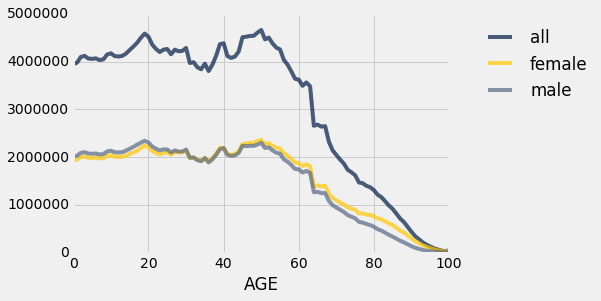

In [11]:
# The number of individuals by ages
pop2010.plot('AGE',overlay=True)

In [12]:
pop2010['diff'] = pop2010['male'] - pop2010['female']
pop2010.show()

AGE,all,female,male,diff
0,3944153,1929877,2014276,84399
1,3978070,1947217,2030853,83636
2,4096929,2004731,2092198,87467
3,4119040,2014490,2104550,90060
4,4063170,1985620,2077550,91930
5,4056858,1984764,2072094,87330
6,4066381,1991062,2075319,84257
7,4030579,1973503,2057076,83573
8,4046486,1981033,2065453,84420
9,4148353,2028657,2119696,91039


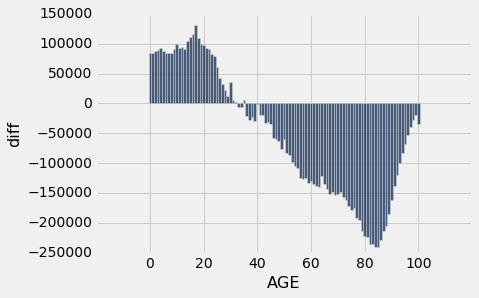

In [13]:
# The difference in the genders by age
pop2010.select(['AGE', 'diff']).bar('AGE')

In [17]:
pop2010['Rel Diff'] = pop2010['diff'] / pop2010['all']
pop2010.set_format('Rel Diff', PercentFormatter)
pop2010.show()

AGE,all,female,male,diff,Rel Diff
0,3944153,1929877,2014276,84399,2.14%
1,3978070,1947217,2030853,83636,2.10%
2,4096929,2004731,2092198,87467,2.13%
3,4119040,2014490,2104550,90060,2.19%
4,4063170,1985620,2077550,91930,2.26%
5,4056858,1984764,2072094,87330,2.15%
6,4066381,1991062,2075319,84257,2.07%
7,4030579,1973503,2057076,83573,2.07%
8,4046486,1981033,2065453,84420,2.09%
9,4148353,2028657,2119696,91039,2.19%


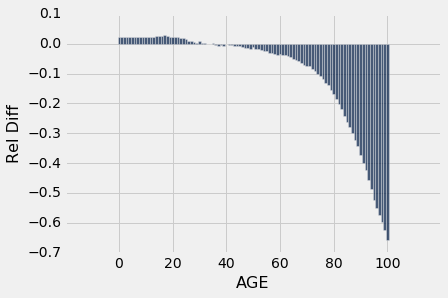

In [18]:
pop2010.select(['AGE', 'Rel Diff']).bar('AGE')

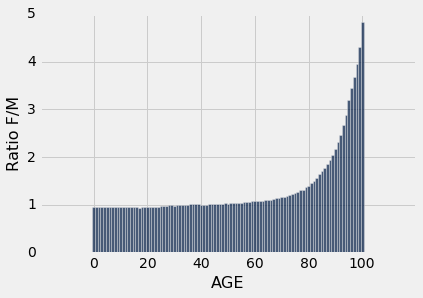

In [19]:
pop2010['Ratio F/M'] = pop2010['female'] / pop2010['male']
pop2010.select(['AGE', 'Ratio F/M']).bar('AGE')